In [0]:
import pandas as pd
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import length
from pyspark.sql.types import Row
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
%pip install nltk

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.5/776.5 kB 47.3 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
#prima installare libreria MAVEN: com.johnsnowlabs.nlp:spark-nlp_2.12:4.3.0
%pip install sparknlp

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 579.2/579.2 kB 8.6 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
import nltk
nltk.download('stopwords')

from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import Normalizer, Tokenizer, LemmatizerModel, StopWordsCleaner

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv
dataset = pd.read_csv('/databricks/driver/wikipedia.csv')
spark_df = spark.createDataFrame(dataset)
spark_df = spark_df.drop("Unnamed: 0")

--2024-07-27 16:46:33--  https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 3.5.224.208, 52.95.154.86
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|3.5.224.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1003477941 (957M) [text/csv]
Saving to: ‘wikipedia.csv’

wikipedia.csv       100%[===================>] 956.99M  15.5MB/s    in 68s     

2024-07-27 16:47:41 (14.1 MB/s) - ‘wikipedia.csv’ saved [1003477941/1003477941]



In [0]:
spark_df.write.saveAsTable("wikipedia_3")

In [0]:
spark_df.show(5)

+--------------------+--------------------+--------------------+---------+
|               title|             summary|           documents|categoria|
+--------------------+--------------------+--------------------+---------+
|           economics|economics () is a...|economics () is a...|economics|
|index of economic...|this aims to be a...|this aims to be a...|economics|
|     cryptoeconomics|cryptoeconomics i...|cryptoeconomics i...|economics|
|economic impact a...|an economic impac...|an economic impac...|economics|
|      economic trend|economic trend ma...|economic trend ma...|economics|
+--------------------+--------------------+--------------------+---------+
only showing top 5 rows



### EDA

In [0]:
display(spark_df.count())

153232

In totale sono presenti 153232 osservazioni.

In [0]:
spark_df = spark_df.dropna()
display(spark_df.count())

152304

Sono state rimosse le osservazioni contententi campi nulli.

In [0]:
spark_df.show(5)

+--------------------+--------------------+--------------------+---------+
|               title|             summary|           documents|categoria|
+--------------------+--------------------+--------------------+---------+
|           economics|economics () is a...|economics () is a...|economics|
|index of economic...|this aims to be a...|this aims to be a...|economics|
|     cryptoeconomics|cryptoeconomics i...|cryptoeconomics i...|economics|
|economic impact a...|an economic impac...|an economic impac...|economics|
|      economic trend|economic trend ma...|economic trend ma...|economics|
+--------------------+--------------------+--------------------+---------+
only showing top 5 rows



#### Numero di articoli per categoria

In [0]:
%sql

select 
categoria, 
count(*) as numero_articoli 
from default.wikipedia_3
group by categoria

categoria,numero_articoli
finance,9863
energy,10033
culture,10155
science,10166
politics,11358
economics,10110
humanities,10116
medicine,10015
sports,10066
engineering,10219


Nel database gli articoli sono suddivisi in 15 categorie; si nota che il numero di articoli è omogeneo per tutte le categorie, il che rende il presente dataset bilanciato.

#### Numero medio di parole utilizzate per categoria
Per ogni categoria presente nel dataset è stato calcolato il numero medio di parole. A tal scopo i testi presenti nella colonna *documents* sono stati tokenizzati, così da avere un vettore composto dalle singole parole, di cui è stata calcolata lunghezza ottenendo così una colonna con il numero di parole per ogni articolo. Tale colonna è stata, in seguito, utilizzata anche per calcolare il numero massimo e minimo di parole per categoria.


In [0]:
tokenizer = Tokenizer(inputCol='documents', outputCol='tok_documents')
df_token = tokenizer.transform(spark_df)


In [0]:
display(df_token.head(5))

title summary documents categoria tok_documents economics economics () is a social science that studies the production, distribution, and consumption of goods and services.economics focuses on the behaviour and interactions of economic agents and how economies work. microeconomics analyzes what's viewed as basic elements in the economy, including individual agents and markets, their interactions, and the outcomes of interactions. individual agents may include, for example, households, firms, buyers, and sellers. macroeconomics analyzes the economy as a system where production, consumption, saving, and investment interact, and factors affecting it: employment of the resources of labour, capital, and land, currency inflation, economic growth, and public policies that have impact on these elements. other broad distinctions within economics include those between positive economics, describing "what is", and normative economics, advocating "what ought to be"; between economic theory and applied economics; between rational and behavioural economics; and between mainstream economics and heterodox economics.economic analysis can be applied throughout society, including business, finance, cybersecurity, health care, engineering and government. it is also applied to such diverse subjects as crime, education, the family, feminism, law, philosophy, politics, religion, social institutions, war, science, and the environment. economics () is a social science that studies the production, distribution, and consumption of goods and services.economics focuses on the behaviour and interactions of economic agents and how economies work. microeconomics analyzes what's viewed as basic elements in the economy, including individual agents and markets, their interactions, and the outcomes of interactions. individual agents may include, for example, households, firms, buyers, and sellers. macroeconomics analyzes the economy as a system where production, consumption, saving, and investment interact, and factors affecting it: employment of the resources of labour, capital, and land, currency inflation, economic growth, and public policies that have impact on these elements. other broad distinctions within economics include those between positive economics, describing "what is", and normative economics, advocating "what ought to be"; between economic theory and applied economics; between rational and behavioural economics; and between mainstream economics and heterodox economics.economic analysis can be applied throughout society, including business, finance, cybersecurity, health care, engineering and government. it is also applied to such diverse subjects as crime, education, the family, feminism, law, philosophy, politics, religion, social institutions, war, science, and the environment. definitions of economics over time the earlier term for the discipline was 'political economy', but since the late 19th century, it has commonly been called 'economics'. the term is ultimately derived from ancient greek οἰκονομία (oikonomia) which is a term for the "way (nomos) to run a household (oikos)", or in other words the know-how of an οἰκονομικός (oikonomikos), or "household or homestead manager". derived terms such as "economy" can therefore often mean "frugal" or "thrifty". by extension then, "political economy" was the way to manage a polis or state. there are a variety of modern definitions of economics; some reflect evolving views of the subject or different views among economists. scottish philosopher adam smith (1776) defined what was then called political economy as "an inquiry into the nature and causes of the wealth of nations", in particular as: a branch of the science of a statesman or legislator [with the twofold objectives of providing] a plentiful revenue or subsistence for the people ... [and] to supply the state or commonwealth with a revenue for the publick services. jean-baptiste say (1803), distinguishing the subject matter from its public-po

In [0]:
df_num_words = df_token.rdd.map(lambda x:
    Row(x['title'], x['documents'], x['categoria'], len(x['tok_documents']))
    ).toDF(schema = ['title', 'documents', 'categoria', 'num_words'])

In [0]:
display(df_num_words.groupBy('categoria').avg('num_words'))

categoria,avg(num_words)
economics,984.2049455984175
politics,1515.6516992428244
culture,653.8663712456918
science,1875.616171552233
sports,602.1093781045103
energy,587.4513106747733
finance,1909.892426239481
humanities,1059.7318109924872
pets,423.1049321086262
trade,641.1518282988872


Databricks visualization. Run in Databricks to view.

#### Numero massimo di parole per categoria

In [0]:
display(df_num_words.groupBy('categoria').max('num_words'))

categoria,max(num_words)
economics,24022
politics,20140
culture,15538
science,29419
sports,19227
energy,23223
finance,33479
humanities,23198
pets,13222
trade,19275


Databricks visualization. Run in Databricks to view.

#### Numero minimo di parole per categoria

In [0]:
display(df_num_words.groupBy('categoria').min('num_words'))

categoria,min(num_words)
economics,10
politics,11
culture,11
science,15
sports,14
energy,9
finance,3
humanities,7
pets,12
trade,16


Databricks visualization. Run in Databricks to view.

#### Parole più rappresentative per categoria
Nella seguente sezione sono mostrate le 20 parole più rappresentative per ogni categoria. 
Al fine di identificare le parole più significative è stata implementata una pipeline che:
* Esegue la tokenizzazione
* Esegue una pulizia del testo eliminando token con caratteri speciali
* Elimina le stopwords così da evitare di mostare come significative parole prive di significato semantico
* Esegue la lemmatizzazione 

In [0]:
nltk.download('stopwords')
stopwords_eng = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
import sparknlp
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, Normalizer, LemmatizerModel, StopWordsCleaner


document_assembler = DocumentAssembler()\
    .setInputCol('documents')\
    .setOutputCol('docs')

#Tokenizer   
tokenizer = Tokenizer()\
    .setInputCols(['docs'])\
    .setOutputCol('tokens')

#Tokens Cleaning
normalizer = Normalizer()\
    .setInputCols(['tokens'])\
    .setOutputCol('cleaned_tokens')

#Removing Stopwords
stop_words_cleaner = StopWordsCleaner()\
    .setInputCols(['cleaned_tokens'])\
    .setOutputCol('no_stop_words_tokens')\
    .setStopWords(stopwords_eng)\
    .setCaseSensitive(False)

#Lemmatizer
lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['no_stop_words_tokens'])\
    .setOutputCol('lemma_tokens')
    

#Conversion to array for spark sql
finisher = Finisher()\
    .setInputCols('lemma_tokens')\
    .setOutputCols(['tokens_docs'])\
    .setOutputAsArray(True)\
    .setCleanAnnotations(False)

preprocessing_pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    normalizer,
    stop_words_cleaner,
    lemmatizer,
    finisher
])




lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [0]:
model = preprocessing_pipeline.fit(spark_df)
df_docs_tokens = model.transform(spark_df)
#display(df_docs_tokens.show(3))

In [0]:
df_docs_tokens.createOrReplaceTempView('cleaned_tokens')

##### Economics

In [0]:
df_sql = spark.sql("select tok, count(*) from (select explode(tokens_docs) as tok from cleaned_tokens where categoria = 'economics')group by 1 order by 2 desc")
df_sql.show(20)

+-------------+--------+
|          tok|count(1)|
+-------------+--------+
|        party|   54534|
|    socialist|   34845|
|   university|   33385|
|         work|   31365|
|          new|   26929|
|       member|   24697|
|       worker|   24220|
|         also|   23128|
|international|   22992|
|        group|   21139|
|       become|   18414|
|       labour|   18076|
|     economic|   17119|
|    economics|   16919|
|        leave|   16161|
|    political|   16035|
|        state|   15734|
|         book|   15709|
|         year|   15586|
|      history|   14972|
+-------------+--------+
only showing top 20 rows



##### Politics

In [0]:
df_sql = spark.sql("select tok, count(*) from (select explode(tokens_docs) as tok from cleaned_tokens where categoria = 'politics')group by 1 order by 2 desc")
df_sql.show(20)

+----------+--------+
|       tok|count(1)|
+----------+--------+
|     party|  171630|
|       one|  155922|
|    nation|  150301|
|    hanson|  133471|
|  election|  114692|
|australian|   98287|
|    latham|   93639|
| australia|   76946|
|     state|   66388|
|       new|   60885|
|queensland|   54018|
|     south|   53690|
|    leader|   51992|
|   federal|   50974|
|    senate|   50711|
|     labor|   50493|
|      vote|   49726|
|      seat|   47290|
|   pauline|   46364|
|      also|   44306|
+----------+--------+
only showing top 20 rows



##### Culture

In [0]:
df_sql = spark.sql("select tok, count(*) from (select explode(tokens_docs) as tok from cleaned_tokens where categoria = 'culture')group by 1 order by 2 desc")
df_sql.show(20)

+---------+--------+
|      tok|count(1)|
+---------+--------+
|     film|   46653|
|   meitei|   32841|
| language|   27632|
|     also|   20962|
|  manipur|   19859|
|    award|   18060|
|    dance|   17330|
|   khamba|   15586|
| manipuri|   15117|
|      one|   13847|
|   indian|   13070|
|    india|   12389|
| festival|   11934|
|       th|   11729|
|    state|   11625|
|     king|   11323|
|    write|   10875|
|    first|   10436|
|reference|   10250|
|      day|    9697|
+---------+--------+
only showing top 20 rows



##### Science

In [0]:
df_sql = spark.sql("select tok, count(*) from (select explode(tokens_docs) as tok from cleaned_tokens where categoria = 'science')group by 1 order by 2 desc")
df_sql.show(20)

+--------+--------+
|     tok|count(1)|
+--------+--------+
|aircraft|  167006|
|     air|  131905|
|   force|   89583|
|  engine|   66718|
|     use|   62766|
|       f|   60032|
|lockheed|   57454|
|  flight|   53024|
|   first|   48561|
|      we|   47885|
|    also|   45635|
|     fly|   45420|
|     two|   44513|
|    film|   40390|
|  system|   39887|
|     one|   39787|
|   state|   36831|
|  design|   35699|
|     new|   35531|
|    base|   35521|
+--------+--------+
only showing top 20 rows



##### Sports

In [0]:
df_sql = spark.sql("select tok, count(*) from (select explode(tokens_docs) as tok from cleaned_tokens where categoria = 'sports')group by 1 order by 2 desc")
df_sql.show(20)

+----------+--------+
|       tok|count(1)|
+----------+--------+
|      open|   41172|
|     first|   34195|
|     final|   30722|
|    tennis|   28772|
|     title|   26971|
|    double|   26324|
|    player|   25222|
|    single|   24959|
|     round|   24292|
|      play|   23922|
|        we|   23529|
|      lose|   23235|
|    defeat|   23091|
|tournament|   21088|
|       set|   20813|
|     match|   19532|
|      year|   19308|
|       win|   18667|
|     world|   18115|
|      polo|   16788|
+----------+--------+
only showing top 20 rows



##### Energy

In [0]:
df_sql = spark.sql("select tok, count(*) from (select explode(tokens_docs) as tok from cleaned_tokens where categoria = 'energy')group by 1 order by 2 desc")
df_sql.show(20)

+-----------+--------+
|        tok|count(1)|
+-----------+--------+
|      power|   85482|
|    station|   47170|
|      plant|   41648|
|    company|   34101|
|     energy|   30795|
|electricity|   25920|
|         mw|   22420|
|       unit|   18586|
|        gas|   17589|
|       also|   16772|
|    project|   15836|
|   electric|   15190|
|   generate|   15015|
|   capacity|   14707|
|        new|   13924|
|      build|   13206|
|        use|   12730|
|      state|   12601|
|    operate|   12577|
|       coal|   12107|
+-----------+--------+
only showing top 20 rows



##### Finance

In [0]:
df_sql = spark.sql("select tok, count(*) from (select explode(tokens_docs) as tok from cleaned_tokens where categoria = 'finance')group by 1 order by 2 desc")
df_sql.show(20)

+---------+--------+
|      tok|count(1)|
+---------+--------+
|   series|   90571|
|  company|   61635|
|     also|   49063|
|   master|   47767|
|      new|   43587|
|      one|   43015|
|    voice|   42708|
| universe|   41703|
|     time|   36768|
|    first|   35567|
|    heman|   35379|
|      use|   34742|
|character|   33679|
|    power|   33561|
|   figure|   33239|
|  include|   32344|
|     film|   32244|
|  cartoon|   32116|
|      man|   31793|
|  release|   31024|
+---------+--------+
only showing top 20 rows



##### Humanities

In [0]:
df_sql = spark.sql("select tok, count(*) from (select explode(tokens_docs) as tok from cleaned_tokens where categoria = 'humanities')group by 1 order by 2 desc")
df_sql.show(20)

+-----------+--------+
|        tok|count(1)|
+-----------+--------+
|       work|   32940|
| university|   26898|
|       also|   24429|
|       film|   22803|
|       late|   22538|
|      first|   18978|
|      study|   18826|
|        new|   18593|
|        one|   18578|
|       year|   18302|
|       time|   18041|
|    society|   16656|
|     become|   16597|
|    history|   15770|
|       make|   15711|
|archaeology|   15623|
|       life|   14859|
|       book|   14426|
|    publish|   14387|
|       find|   14228|
+-----------+--------+
only showing top 20 rows



##### Pets

In [0]:
df_sql = spark.sql("select tok, count(*) from (select explode(tokens_docs) as tok from cleaned_tokens where categoria = 'pets')group by 1 order by 2 desc")
df_sql.show(20)

+---------+--------+
|      tok|count(1)|
+---------+--------+
|      dog|   22815|
|    breed|   19684|
|  species|   17017|
|      cat|   16820|
|     race|   13861|
|greyhound|   13822|
|     also|   13400|
|  stadium|   12452|
|     fish|   11314|
|reference|   10314|
|    first|   10238|
|    track|    9151|
|     year|    8752|
|      one|    8067|
|     name|    7481|
|     show|    7416|
|     club|    7373|
|      use|    7165|
|      new|    7089|
|  include|    6968|
+---------+--------+
only showing top 20 rows



##### Trade

In [0]:
df_sql = spark.sql("select tok, count(*) from (select explode(tokens_docs) as tok from cleaned_tokens where categoria = 'trade')group by 1 order by 2 desc")
df_sql.show(20)

+--------+--------+
|     tok|count(1)|
+--------+--------+
|    park|   27965|
|mountain|   24042|
|national|   21995|
| glacier|   21684|
|   river|   20136|
|     new|   18617|
|    also|   18497|
|    lake|   17857|
|   state|   16028|
| company|   15965|
|    fort|   15879|
|   trade|   14755|
|    bear|   14185|
|   north|   13412|
|    year|   13135|
|   first|   12498|
|    name|   11386|
|american|   11243|
|     one|   11230|
|      we|   10855|
+--------+--------+
only showing top 20 rows



##### Technology

In [0]:
df_sql = spark.sql("select tok, count(*) from (select explode(tokens_docs) as tok from cleaned_tokens where categoria = 'technology')group by 1 order by 2 desc")
df_sql.show(20)

+--------+--------+
|     tok|count(1)|
+--------+--------+
|    game|   51408|
|     use|   36740|
| release|   36200|
|    also|   31074|
|  system|   27068|
| version|   24889|
| include|   23875|
|    user|   21499|
|     new|   21137|
|software|   20543|
|   linux|   20533|
| support|   19771|
|computer|   19333|
| feature|   18978|
|     one|   18382|
|   first|   18291|
|  player|   17609|
| android|   17051|
|  device|   15887|
|    work|   15166|
+--------+--------+
only showing top 20 rows



##### Transport

In [0]:
df_sql = spark.sql("select tok, count(*) from (select explode(tokens_docs) as tok from cleaned_tokens where categoria = 'transport')group by 1 order by 2 desc")
df_sql.show(20)

+---------+--------+
|      tok|count(1)|
+---------+--------+
|  station|   69028|
|   bridge|   62527|
|     line|   34807|
|  airport|   25546|
|      new|   25449|
|  service|   20362|
|     open|   19141|
|    build|   18886|
|  railway|   17084|
|     also|   15959|
|   flight|   15575|
|      use|   15385|
| platform|   15145|
| terminal|   14885|
|      two|   14500|
|     city|   13723|
|   street|   12245|
|passenger|   11973|
|      one|   11961|
|    train|   11591|
+---------+--------+
only showing top 20 rows



##### Medicine

In [0]:
df_sql = spark.sql("select tok, count(*) from (select explode(tokens_docs) as tok from cleaned_tokens where categoria = 'medicine')group by 1 order by 2 desc")
df_sql.show(20)

+----------+--------+
|       tok|count(1)|
+----------+--------+
|  hospital|   65320|
|    health|   28424|
|   medical|   27317|
|       new|   25969|
|university|   25083|
|      also|   21948|
|  medicine|   20584|
|  research|   20186|
|     first|   17221|
|    school|   16170|
|      work|   15395|
|    center|   15153|
|       use|   14640|
|   include|   14608|
|  american|   14342|
|      year|   13447|
|       one|   13419|
|     award|   13405|
|   service|   13183|
|     state|   13084|
+----------+--------+
only showing top 20 rows



##### Engineering

In [0]:
df_sql = spark.sql("select tok, count(*) from (select explode(tokens_docs) as tok from cleaned_tokens where categoria = 'engineering')group by 1 order by 2 desc")
df_sql.show(20)

+-------+--------+
|    tok|count(1)|
+-------+--------+
|  river|   24357|
|    use|   22064|
|  water|   21282|
|   also|   21187|
|   work|   16235|
|  build|   14372|
|  first|   14323|
|dresden|   13720|
|    one|   12977|
|   year|   12945|
|include|   12619|
|    new|   12155|
| bridge|   12039|
| design|   11922|
| system|   11309|
| german|   11252|
|company|   10831|
|   make|   10625|
| become|   10473|
|   time|   10462|
+-------+--------+
only showing top 20 rows



##### Research

In [0]:
df_sql = spark.sql("select tok, count(*) from (select explode(tokens_docs) as tok from cleaned_tokens where categoria = 'research')group by 1 order by 2 desc")
df_sql.show(20)

+----------+--------+
|       tok|count(1)|
+----------+--------+
|  research|   48926|
|university|   38408|
|   medical|   24286|
|   science|   21856|
|      work|   21820|
|     award|   20998|
|     study|   20739|
|    health|   20635|
| institute|   19769|
|      also|   18227|
|  medicine|   17677|
|  national|   15240|
|   disease|   14686|
|    school|   14196|
| professor|   13925|
|       new|   13762|
|    cancer|   12858|
|  american|   12475|
|     first|   12434|
|       use|   12344|
+----------+--------+
only showing top 20 rows



### Modello Classificazione Testuale
In questa sezione è stato implementato un modello in grado di classificare il testo in una delle categorie del dataset. In particolare è scelto un modello di Naive-Bayes in quanto, oltre ad essere molto utilizzato in questo ambito, risulta perticolarmente efficente dal punto di vista computazionale. 

Il testo è stato preprocessato utilizzando la stessa pipeline descritta in precedenza a cui è stato aggiunto:
* Un'istanza della classe *StringIndexer*, per codificare ogni categroia mediante un valore numerico
* Un'istanza della classe *CountVectorizer*, per contare le occorrenze dei 10000 termini più utilizzati del corpus di testo in ciascun articolo
* Un'istanza della classe *NaiveBayes*, per realizzare il modello vero e proprio.

Sono stati realizzati due modelli, uno utilizzando come corpus di testo di addestramento la colonna *documents* e uno con quella *summary*.

In [0]:
from pyspark.ml.feature import StringIndexer, CountVectorizer
from pyspark.ml.classification import NaiveBayes


In [0]:
#encoder col categoria
label_encoder = StringIndexer(inputCol='categoria', outputCol='label')

#vectorizer
count_vect = CountVectorizer(inputCol='tokens_docs', outputCol='features', vocabSize=10000)

#naive-bayes model
nb = NaiveBayes(featuresCol='features', labelCol='label', modelType='multinomial')

In [0]:
pipeline_nb = Pipeline(stages=[
    document_assembler,
    tokenizer,
    normalizer,
    stop_words_cleaner,
    lemmatizer,
    finisher,
    label_encoder,
    count_vect,
    nb
])

#### Classificazione Documenti

Il dataset è stato suddiviso in Training e Test Set.

In [0]:
train, test = spark_df.randomSplit([0.8, 0.2], seed = 0)

Il Training Set è stato utilizzato per allenare il modello.

In [0]:
model = pipeline_nb.fit(train)

java.io.IOException: Connection failed
	at com.databricks.rpc.Jetty9Client$$anon$1.handleError(Jetty9Client.scala:848)
	at com.databricks.rpc.Jetty9Client$$anon$1.onFailure(Jetty9Client.scala:775)
	at shaded.v9_4.org.eclipse.jetty.client.ResponseNotifier.notifyFailure(ResponseNotifier.java:197)
	at shaded.v9_4.org.eclipse.jetty.client.ResponseNotifier.notifyFailure(ResponseNotifier.java:189)
	at shaded.v9_4.org.eclipse.jetty.client.HttpExchange.notifyFailureComplete(HttpExchange.java:275)
	at shaded.v9_4.org.eclipse.jetty.client.HttpExchange.abort(HttpExchange.java:247)
	at shaded.v9_4.org.eclipse.jetty.client.HttpConversation.abort(HttpConversation.java:164)
	at shaded.v9_4.org.eclipse.jetty.client.HttpRequest.abort(HttpRequest.java:821)
	at shaded.v9_4.org.eclipse.jetty.client.HttpDestination.abort(HttpDestination.java:559)
	at shaded.v9_4.org.eclipse.jetty.client.HttpDestination.failed(HttpDestination.java:313)
	at com.databricks.rpc.AbstractConnectionPool$1.failed(AbstractConnectionPool.java:161)
	at shaded.v9_4.org.eclipse.jetty.util.Promise$Wrapper.failed(Promise.java:136)
	at com.databricks.rpc.Jetty9Client$DatabricksHttpDestinationOverHTTP$$anon$2.failed(Jetty9Client.scala:1671)
	at shaded.v9_4.org.eclipse.jetty.util.Promise$Wrapper.failed(Promise.java:136)
	at shaded.v9_4.org.eclipse.jetty.client.HttpClient$1$1.failed(HttpClient.java:660)
	at shaded.v9_4.org.eclipse.jetty.client.AbstractConnectorHttpClientTransport.connectFailed(AbstractConnectorHttpClientTransport.java:138)
	at shaded.v9_4.org.eclipse.jetty.client.AbstractConnectorHttpClientTransport$ClientSelectorManager.connectionFailed(AbstractConnectorHttpClientTransport.java:188)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$Connect.failed(ManagedSelector.java:966)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.processConnect(ManagedSelector.java:369)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.access$1700(ManagedSelector.java:65)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.processSelected(ManagedSelector.java:676)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.produce(ManagedSelector.java:535)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.produceTask(EatWhatYouKill.java:362)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.doProduce(EatWhatYouKill.java:186)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.tryProduce(EatWhatYouKill.java:173)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.run(EatWhatYouKill.java:131)
	at shaded.v9_4.org.eclipse.jetty.util.thread.ReservedThreadExecutor$ReservedThread.run(ReservedThreadExecutor.java:409)
	at com.databricks.rpc.ShadedInstrumentedQueuedThreadPool$$anon$2.$anonfun$run$4(InstrumentedQueuedThreadPool.scala:173)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:48)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:279)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:275)
	at com.databricks.logging.AttributionContextTracing.withAttributionContext(AttributionContextTracing.scala:46)
	at com.databricks.logging.AttributionContextTracing.withAttributionContext$(AttributionContextTracing.scala:43)
	at com.databricks.rpc.ShadedInstrumentedQueuedThreadPool.withAttributionContext(InstrumentedQueuedThreadPool.scala:125)
	at com.databricks.rpc.ShadedInstrumentedQueuedThreadPool$$anon$2.$anonfun$run$3(InstrumentedQueuedThreadPool.scala:173)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.instrumentation.QueuedThreadPoolInstrumenter.trackActiveThreads(QueuedThreadPoolInstrumenter.scala:110)
	at com.databricks.instrumentation.QueuedThreadPoolInstrume

Il tempo massimo di esecuzione di Databricks Community Edition di 60 minuti non è stato sufficiente per concludere l'addestramento utilizzando l'intero Training Set. Si è quindi deciso di utilizzare come Training Set per l'addestramento il 20% del Training Set estratto inizialmente, pari al 16% dell'intero dataset.

In [0]:
train_2, test_2 = train.randomSplit([0.2, 0.8], seed = 0)

In [0]:
model = pipeline_nb.fit(train_2)

Il modello allenato è stato valutato sul Test Set estratto inizialemente (*test*), utilizzando come metrica l'F1-score, media armonica di precisione e recall.

In [0]:
df_test = model.transform(test)

In [0]:
evaluator = MulticlassClassificationEvaluator(labelCol='label')

In [0]:
evaluator.evaluate(df_test)

0.8486265396913245

Il valore di F1-score ottenuto è pari a circa 0,845, risultato abbastanza soddisfacente.

#### Classificazione Summary

Lo stesso modello è stato allenato utilizzando la colonna *summary* e valutato sullo stesso Test Set.

In [0]:
spark_df.show(5)

+--------------------+--------------------+--------------------+---------+
|               title|             summary|           documents|categoria|
+--------------------+--------------------+--------------------+---------+
|           economics|economics () is a...|economics () is a...|economics|
|index of economic...|this aims to be a...|this aims to be a...|economics|
|     cryptoeconomics|cryptoeconomics i...|cryptoeconomics i...|economics|
|economic impact a...|an economic impac...|an economic impac...|economics|
|      economic trend|economic trend ma...|economic trend ma...|economics|
+--------------------+--------------------+--------------------+---------+
only showing top 5 rows



In [0]:
document_assembler.setInputCol('summary')

DocumentAssembler_c48ce9a0fe1a

In [0]:
model_summary = pipeline_nb.fit(train_2)

In [0]:
df_test = model_summary.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol='label')
evaluator.evaluate(df_test)

0.8665050247479213

In questo caso l'F1-score ottenuto è stato di 0,867, leggermente superiore rispetto a quello raggiunto con la colonna *documents*.

#### Tuning Iperparametri
I due modelli precedenti sono stati addestrati utilizzando il valore di default degli iperparametri *smoothing* e *modelType*. Nella seguente sezione è stato eseguito il tuning di tali iperparametri, solo sul modello che utilizza la colonna *summary* per esigenze computazionali, al fine di ottimizzare le prestazioni del modello in termini di F1-score ottenuto sul Validation Set. 
Considerando l'elevato costo computazionale della cross-validation e il limite di tempo di esecuzione di Databricks Community Edition si è deciso di procedere con lo split del Training Set ridotto (*train_2*) in Training Set e Validation Set (*train_3, test_3*), sebbene la cross-validation rappresenti il metodo migliore per eseguire il tuning.

In [0]:
nltk.download('stopwords')
stopwords_eng = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
train_3, test_3 = train_2.randomSplit([0.8, 0.2], seed = 0)

In [0]:
import numpy as np

smoothing = [0.4, 0.6, 0.8, 1.0]

model_type = ['complement', 'multinomial']


evaluator = MulticlassClassificationEvaluator(labelCol='label')


f1_score = []
params = []

for s in smoothing:
    for mt in model_type:

        nb.setSmoothing(s)
        nb.setModelType(mt)

        model_tuning = pipeline_nb.fit(train_3)
        df_test = model_tuning.transform(test_3)

        f1_score.append(evaluator.evaluate(df_test))
        params.append((s, mt))


In [0]:
np.max(f1_score)

0.8721249484625844

Il modello ottimizzato raggiunge il valore di F1-score pari a 0,872.

In [0]:
print(f'Best Hyperparameters:\n-Smoothing: {params[np.argmax(f1_score)][0]}\n-Model Type: {params[np.argmax(f1_score)][1]}')

Best Hyperparameters:
-Smoothing: 0.8
-Model Type: complement


Nel seguente grafico è mostrato il valore di F1-score per tutti i modelli testati durante il tuning degli iperparametri. 

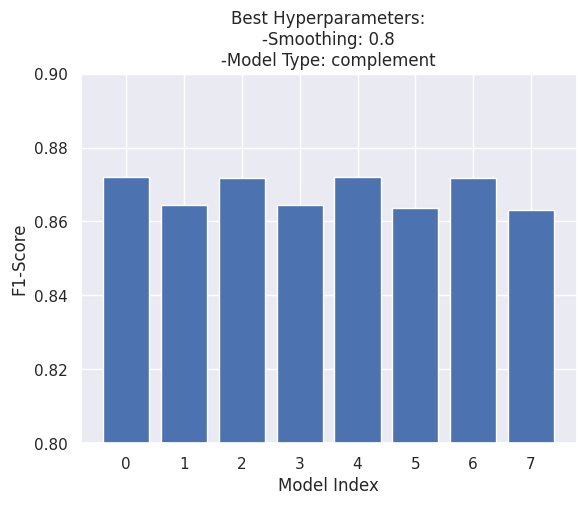

In [0]:
sns.set_theme()
plt.bar(x = np.arange(start = 0, stop = 8), height=f1_score)
plt.axis(ymin = 0.8, ymax = 0.9)
plt.xlabel('Model Index')
plt.ylabel('F1-Score')
plt.title(f'Best Hyperparameters:\n-Smoothing: {params[np.argmax(f1_score)][0]}\n-Model Type: {params[np.argmax(f1_score)][1]}')
plt.show()

Una volta individuati i valori degli iperparamertri che consentono di ottenere il risultato migliore in termini di F1-score, questi sono stati utilizzati per addestrare un modello utilizzando il Training Set ridotto (*train_2*).

Infine, questo è stato valutato sul Test Set iniziale ottendendo un valore di F1-score di 0,872, leggermente migliore rispetto al modello precedente.

In [0]:
nb.setSmoothing(0.8)
nb.setModelType('complement')

model_summary = pipeline_nb.fit(train_2)

In [0]:
df_test = model_summary.transform(test)
evaluator.evaluate(df_test)

0.8718244962784648

### Conclusioni
In questo progetto, è stata eseguita un'indagine esplorativa del dataset che ha consentito di ricavare informazioni riguardo la lunghezza e la composizione degli articoli per ogni categoria.

In seguito sono stati addestrati, su un Training Set ridotto per esigenze computazionali, due modelli basati sul teorema di Naive-Bayes, utilizzando le colonne *documents* e *summary* per l'addestramento. Le performance di tali modelli sono risultate soddisfacenti in termini di F1-score e piuttosto simili. Il modello addestrato sulla colonna *summary* è risultato migliore, seppur di poco, rispetto a quello addestrato sulla colonna *documents*.
Sul modello addestrato con la colonna *summary* è stato eseguito il tuning degli iperparametri per ottimizzarne le prestazioni, tale operazione ha consentito di migliorare, anche se non sensibilmente, il valore di F1-score ottenuto dal modello sul Test Set.